In [186]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector
import statsmodels.api as sm

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [187]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [188]:
df = pd.read_csv("C:\\Users\\Bruger\\Downloads\\cardox.csv")

df['date'] = pd.to_datetime(df['date'])

In [189]:
print(df.head())
df.tail()

        date   value
0 1958-03-01  315.71
1 1958-04-01  317.45
2 1958-05-01  317.50
3 1958-06-01  317.10
4 1958-07-01  315.86


,date,value
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00
728,2018-11-01,408.02


In [190]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    729 non-null    datetime64[ns]
 1   value   729 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB
None
            value
count  729.000000
mean   353.787229
std     27.547500
min    312.660000
25%    328.570000
50%    351.410000
75%    375.990000
max    411.240000


In [191]:
print(df.isnull().sum())

date     0
value    0
dtype: int64


In [192]:
print(df.duplicated().sum())

0


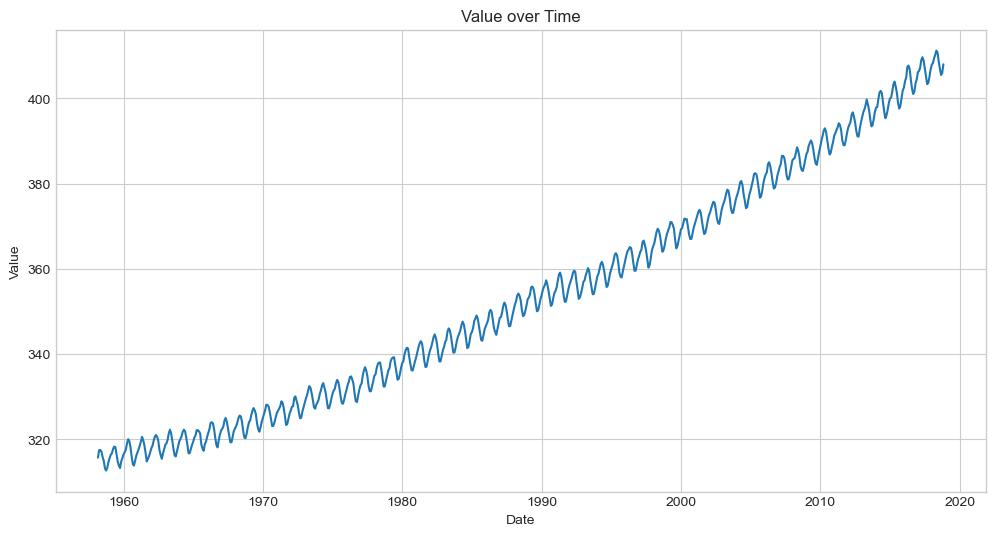

In [193]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Value over Time')
plt.grid(True)
plt.show()

[<AxesSubplot:>]

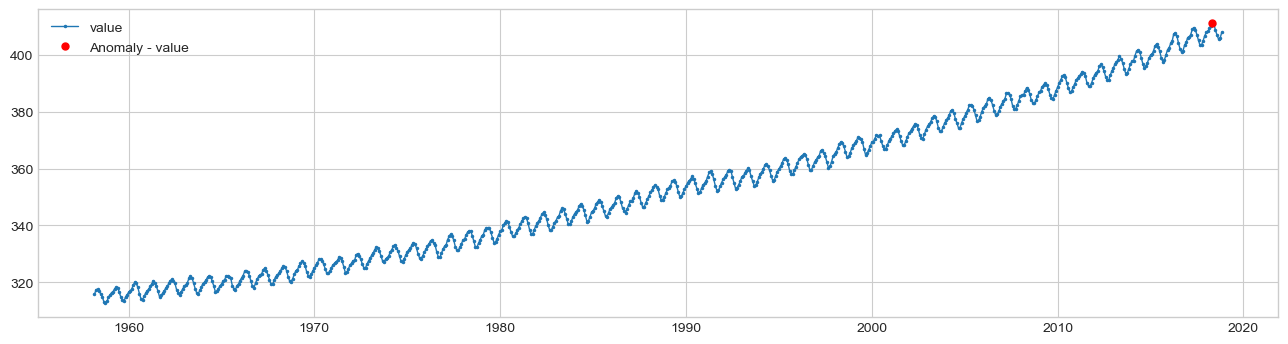

In [194]:
df.set_index('date', inplace=True)
ts_data = validate_series(df['value'])
threshold_ad = ThresholdAD(high=411, low=312)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

In [195]:
anomalies[anomalies.value]

,value
date,
2018-05-01,True


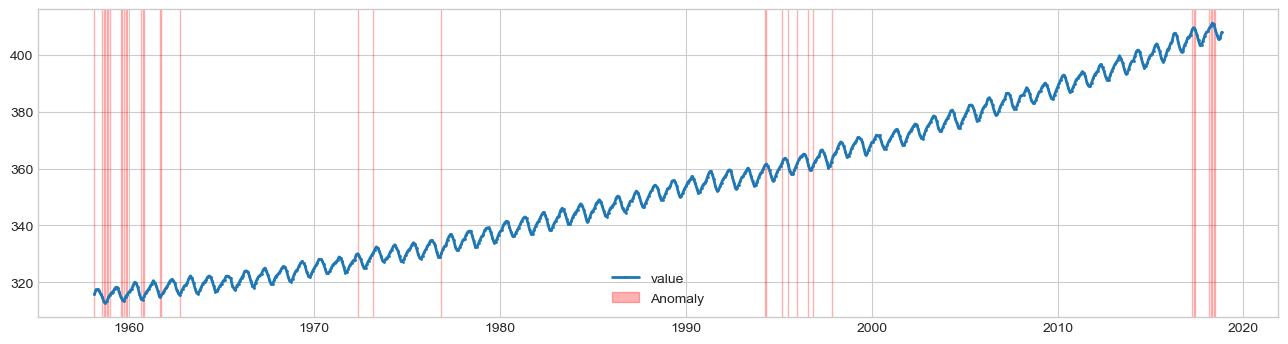

In [196]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [197]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

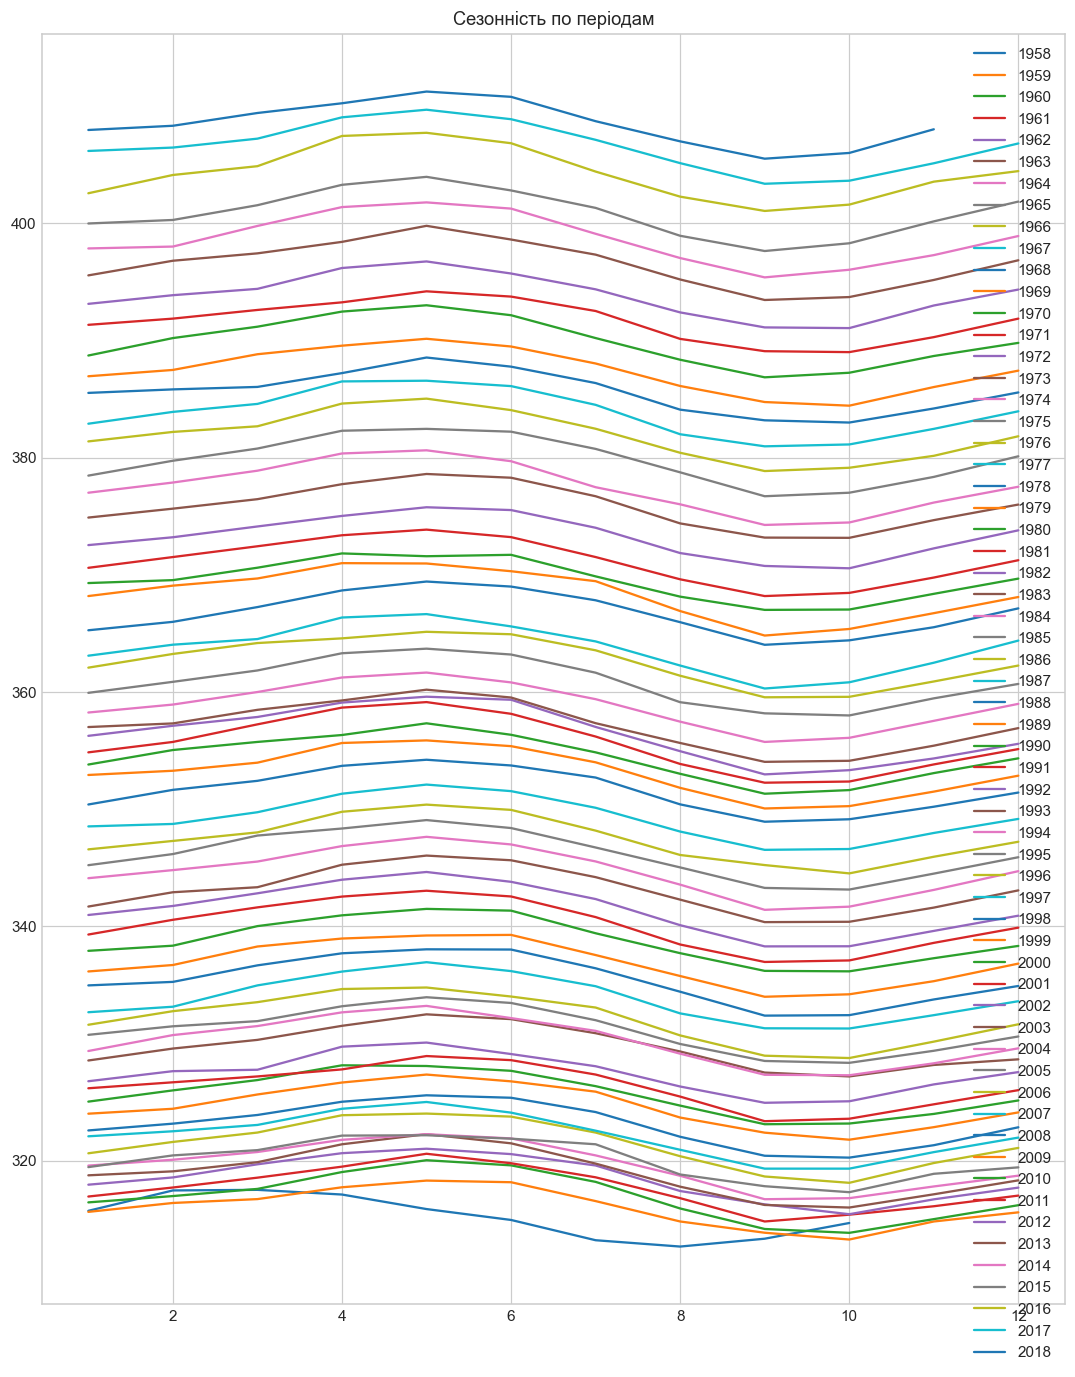

In [198]:
def sesonal(data, s):
    plt.figure(figsize=(12, 15), dpi=110)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()


sesonal(df, 12)

Text(0.5, 0.98, 'Мультиплікатива модель')

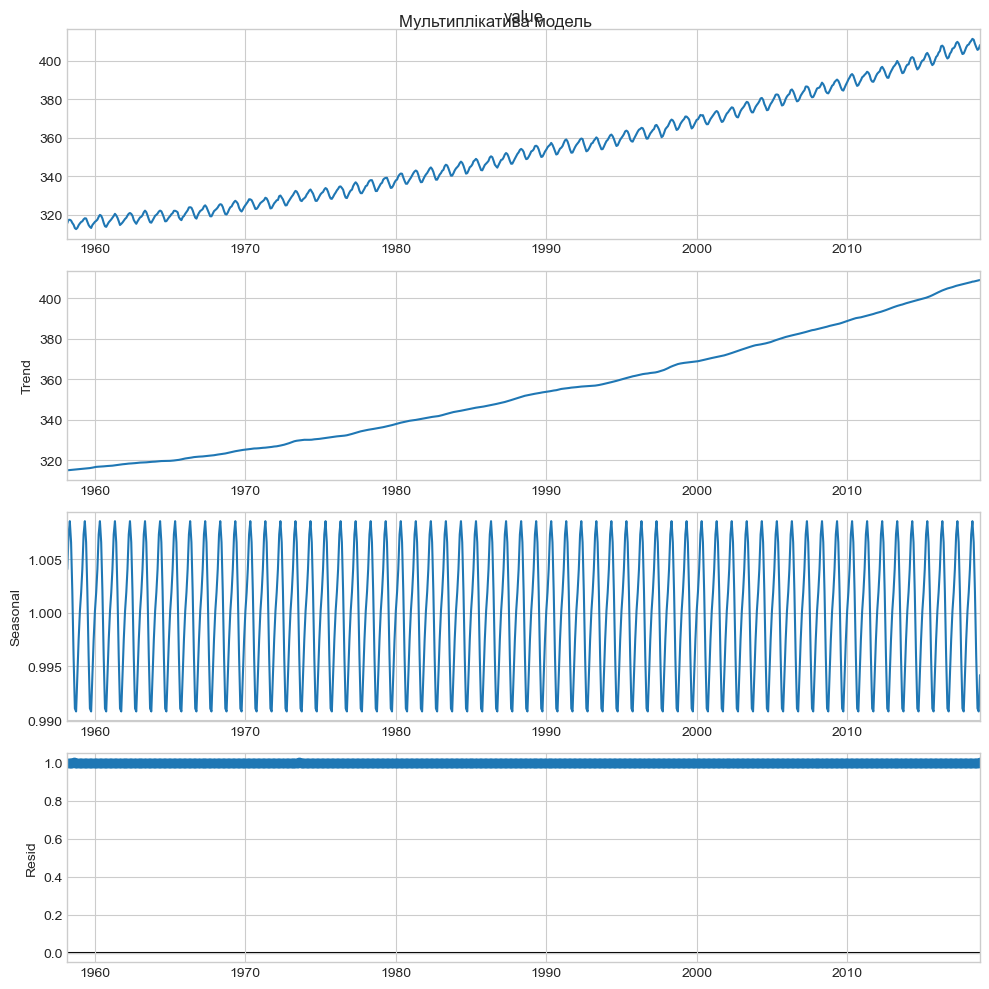

In [199]:
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

Text(0.5, 0.98, 'Адитивна модель')

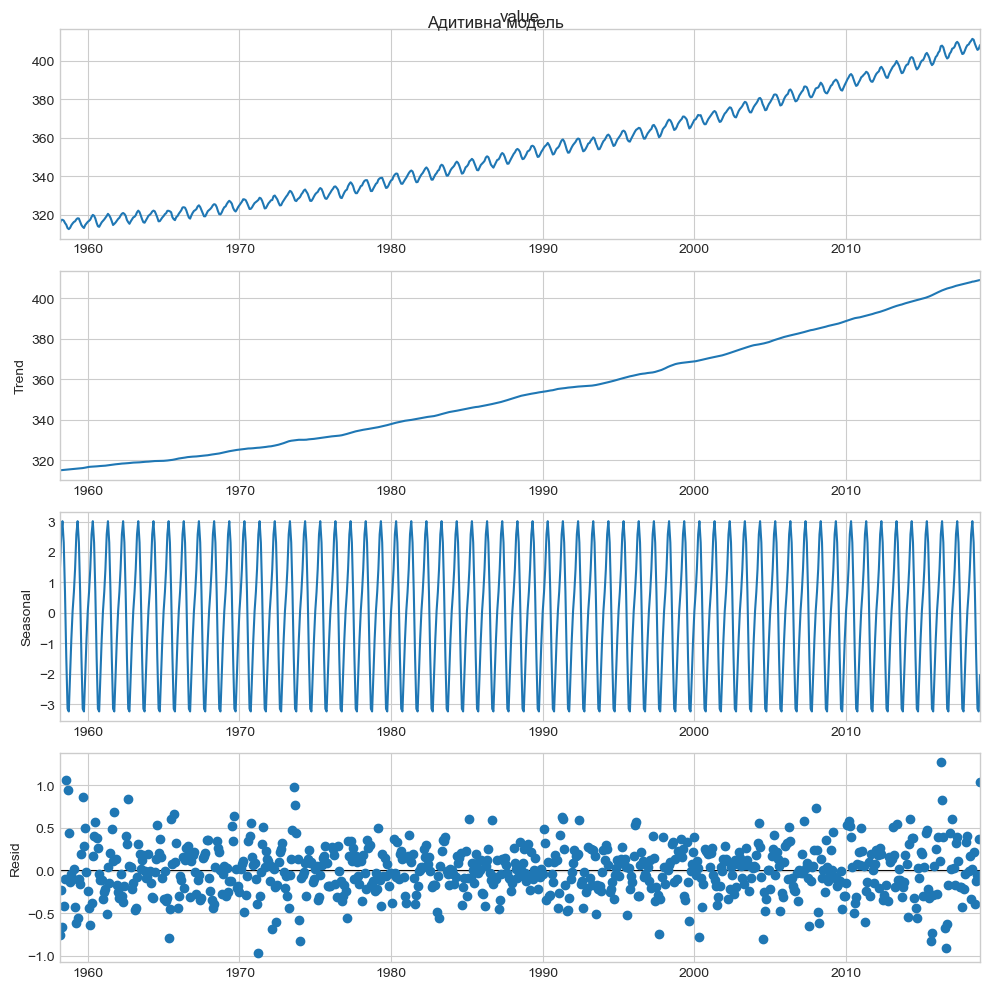

In [200]:
result_M = seasonal_decompose(df.value, model='additive', extrapolate_trend=12)

plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Адитивна модель')

In [201]:
df.index = pd.to_datetime(df.index)
df = df[df.index.year != 1958]

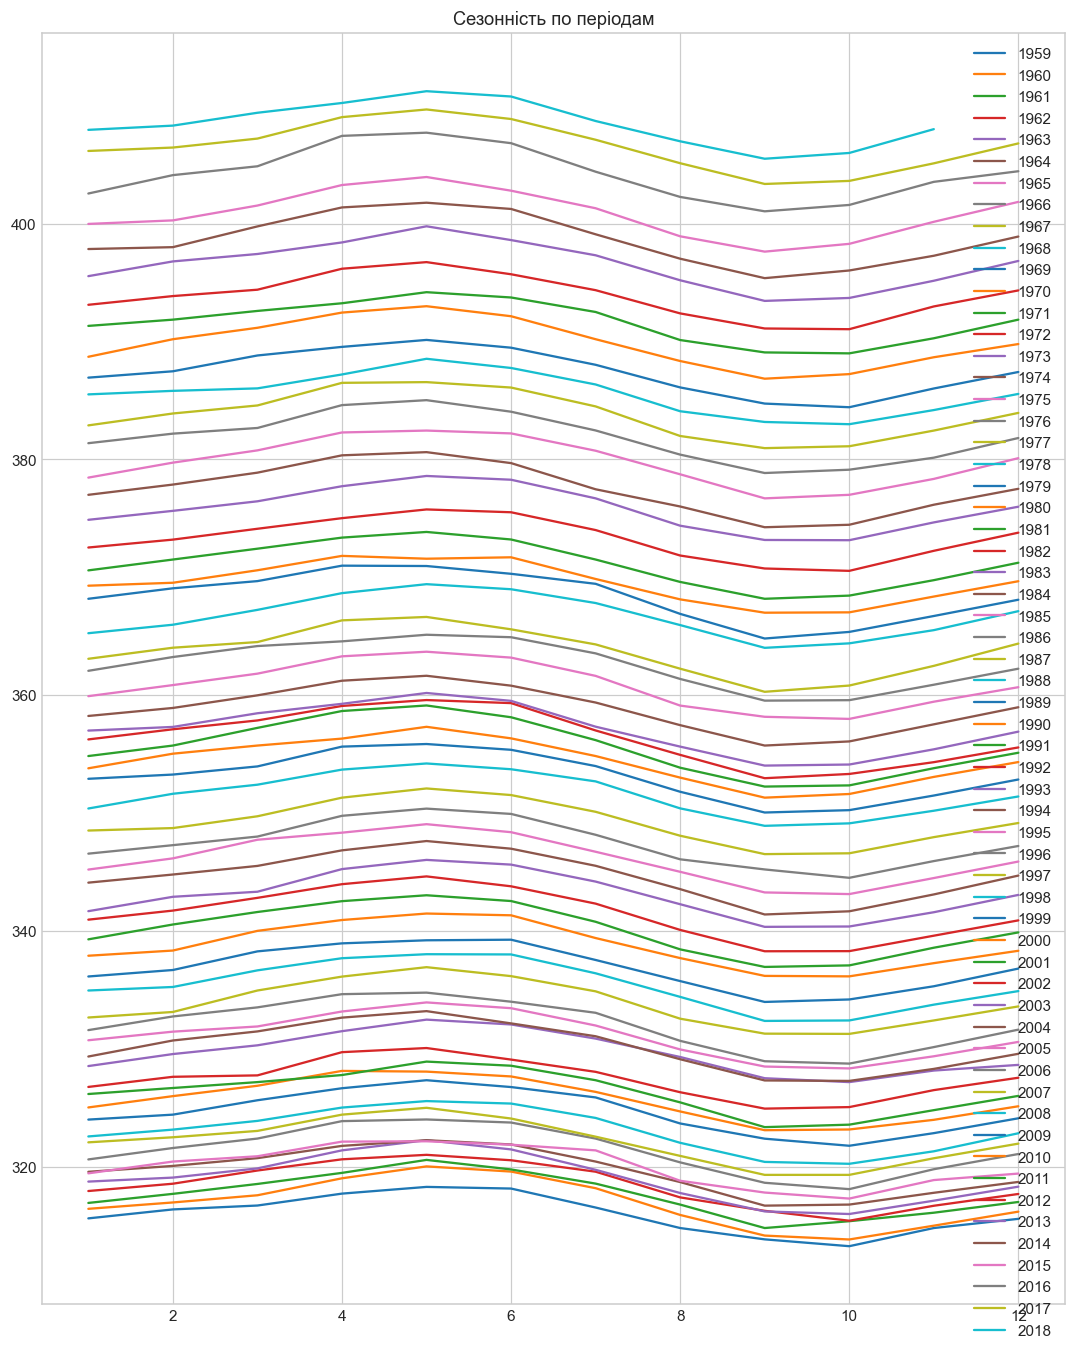

In [202]:
sesonal(df,12)

In [203]:
train=df['2009':'2017']
train.head()

,value
date,
2009-01-01,386.94
2009-02-01,387.48
2009-03-01,388.82
2009-04-01,389.55
2009-05-01,390.14


In [204]:
test=df['2018']
test.head()

,value
date,
2018-01-01,407.96
2018-02-01,408.32
2018-03-01,409.41
2018-04-01,410.24
2018-05-01,411.24


In [205]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [206]:
fit1.params

{'smoothing_level': 0.5235376723256973,
 'smoothing_trend': 6.823292584469541e-15,
 'smoothing_seasonal': 8.568603447889328e-17,
 'damping_trend': nan,
 'initial_level': 387.52758009820116,
 'initial_trend': 0.19629010607550273,
 'initial_seasons': array([0.99775247, 0.99917527, 1.00112717, 1.00433398, 1.0055124 ,
        1.00290399, 0.99818818, 0.99244201, 0.98835726, 0.98851889,
        0.99200845, 0.9951561 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [207]:
fit1.fittedvalues

date
2009-01-01    386.852449
2009-02-01    387.646132
2009-03-01    388.512770
2009-04-01    390.115754
2009-05-01    390.474322
                 ...    
2017-08-01    404.970644
2017-09-01    403.580930
2017-10-01    403.730518
2017-11-01    405.297636
2017-12-01    406.685692
Length: 108, dtype: float64

In [208]:
forecast_values = fit1.forecast(steps=360)

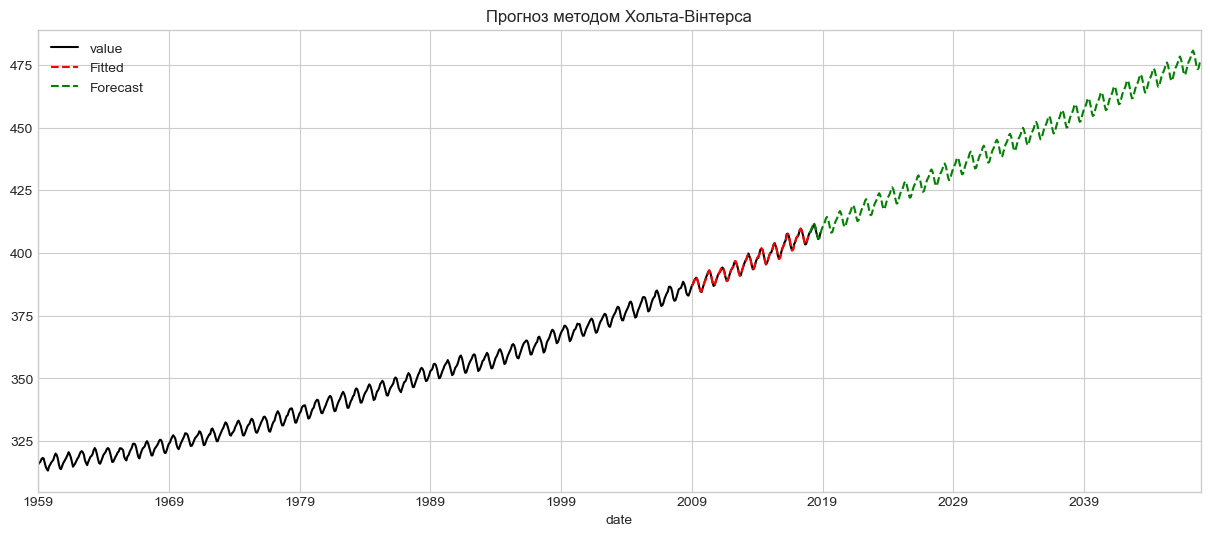

In [209]:
ax = df.plot(figsize=(15, 6), color='black', title="Прогноз методом Хольта-Вінтерса")
fit1.fittedvalues.plot(ax=ax, style='--', color='red', label='Fitted')
forecast_values.plot(ax=ax, style='--', color='green', label='Forecast')
plt.legend()
plt.show()

In [210]:
metrics(train, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -9.640
	P-значення = 0.000
Критичне значення :
	1%: -3.492995948509562 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.888954648057252 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.58139291903223 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2456
MSE: 0.101
MAPE: 0.0006
MPE: -0.0
Стандартна похибка: 0.3179


In [211]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -0.156
	P-значення = 0.944
Критичне значення :
	1%: -4.6651863281249994 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.3671868750000002 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.802960625 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.4072
MSE: 0.2521
MAPE: 0.001
MPE: -0.0008
Стандартна похибка: 0.5021


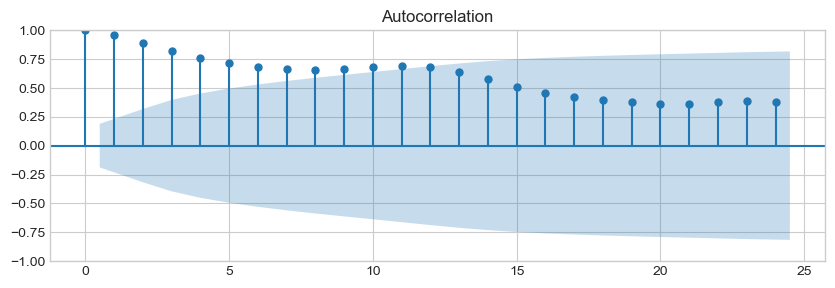

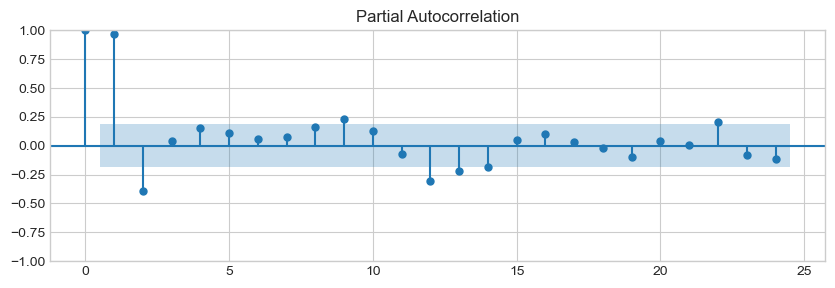

In [212]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.value, lags=24)
plot_pacf(train.value, lags=24)
plt.show()

In [213]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=185.326, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=110.889, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=137.552, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=448.051, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=138.074, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=106.500, Time=1.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=105.292, Time=1.93 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=103.312, Time=1.32 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=101.901, Time=0.82 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=103.347, Time=0.91 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=172.585, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=96.616, Time=0.59 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True)

In [214]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 0),
                                seasonal_order=(1, 1, 2, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6310      0.101      6.219      0.000       0.432       0.830
ar.L2          0.3618      0.098      3.689      0.000       0.170       0.554
ar.S.L12       0.9462      0.280      3.384      0.001       0.398       1.494
ma.S.L12      -1.8750      2.925     -0.641      0.521      -7.607       3.857
ma.S.L24       0.9473      2.918      0.325      0.745      -4.771       6.666
sigma2         0.1122      0.316      0.356      0.722      -0.506       0.731


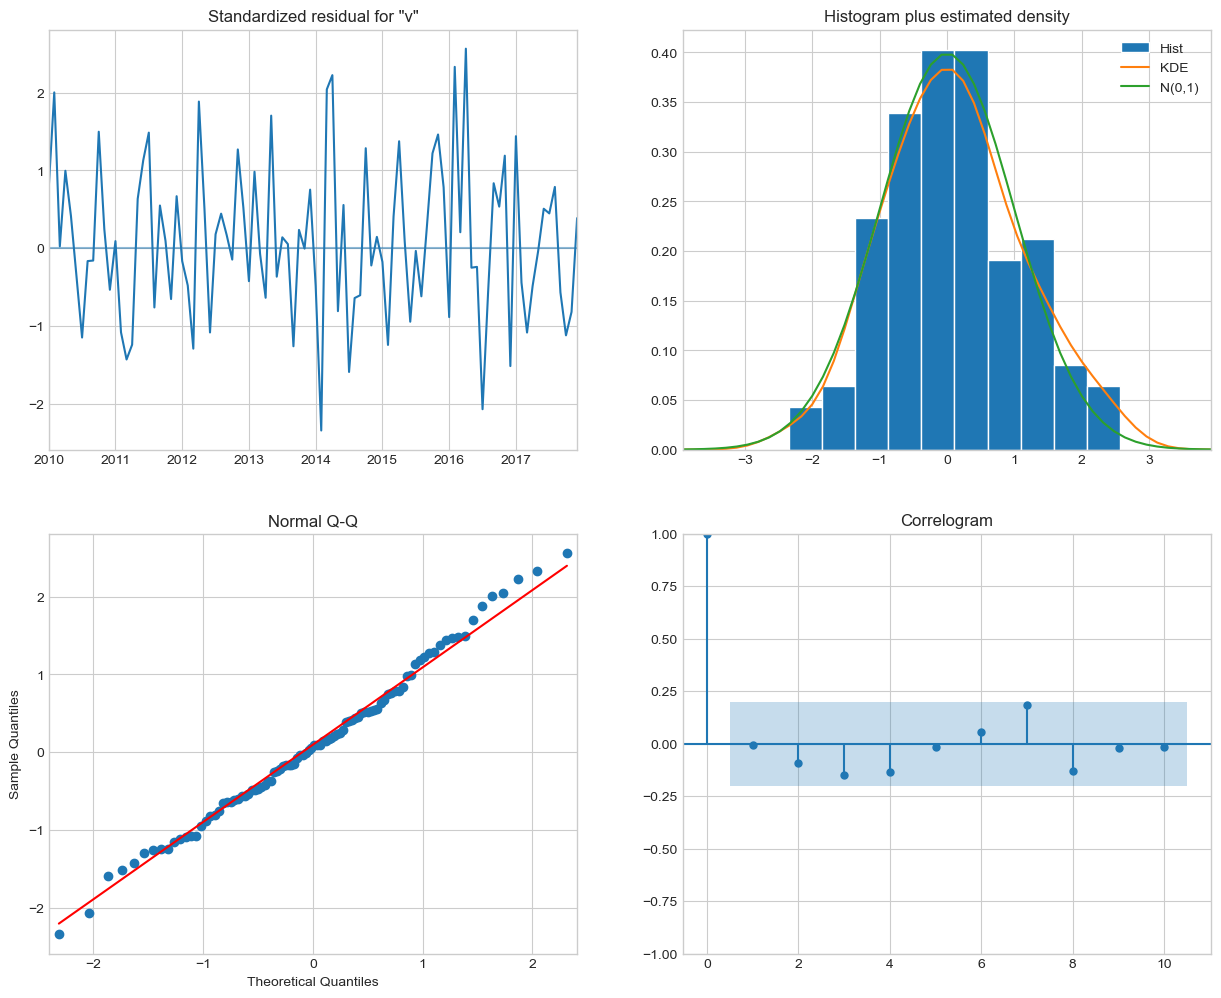

In [215]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [216]:
predict=results.get_prediction()
predict.predicted_mean[:12]

2009-01-01    0.000000
2009-02-01    0.001967
2009-03-01    0.003925
2009-04-01    0.005863
2009-05-01    0.007784
2009-06-01    0.009685
2009-07-01    0.011561
2009-08-01    0.013407
2009-09-01    0.015221
2009-10-01    0.017007
2009-11-01    0.018768
2009-12-01    0.020520
Freq: MS, Name: predicted_mean, dtype: float64

In [217]:
predict=results.get_prediction(start='2009-01-01')
metrics(train['2009-01-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -2.906
	P-значення = 0.045
Критичне значення :
	1%: -3.492995948509562 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.888954648057252 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.58139291903223 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 43.3336
MSE: 16677.6193
MAPE: 0.1118
MPE: 0.1112
Стандартна похибка: 129.1419


In [218]:
predict=results.get_prediction(start='2018', end='2048')

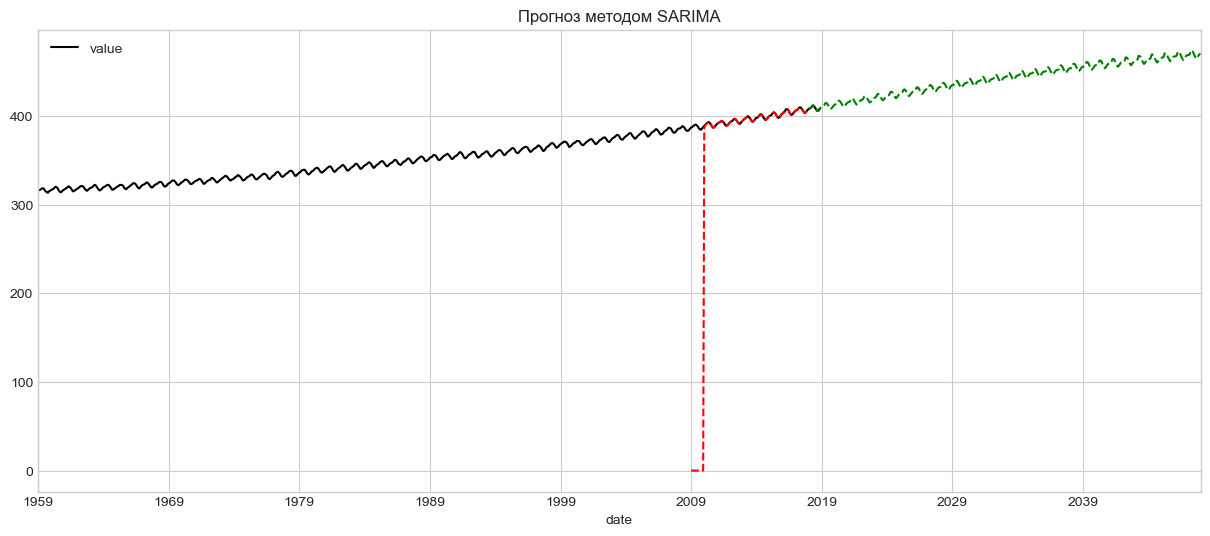

In [219]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [220]:
predict=results.get_prediction(start='2018-01-01', end='2018-11-01')
metrics(test[:11], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -1.592
	P-значення = 0.488
Критичне значення :
	1%: -4.9386902332361515 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.477582857142857 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.8438679591836733 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.3248
MSE: 0.2396
MAPE: 0.0008
MPE: -0.0005
Стандартна похибка: 0.4895


In [221]:
predict.predicted_mean

2018-01-01    407.788531
2018-02-01    408.448243
2018-03-01    409.394107
2018-04-01    411.462941
2018-05-01    412.063154
2018-06-01    411.085026
2018-07-01    409.170838
2018-08-01    406.961092
2018-09-01    405.426879
2018-10-01    406.012851
2018-11-01    407.689172
Freq: MS, Name: predicted_mean, dtype: float64

In [222]:
res_cardox=predict.predicted_mean

In [223]:
res_cardox['2018-01-01']=407

In [224]:
res_cardox

2018-01-01    407.000000
2018-02-01    408.448243
2018-03-01    409.394107
2018-04-01    411.462941
2018-05-01    412.063154
2018-06-01    411.085026
2018-07-01    409.170838
2018-08-01    406.961092
2018-09-01    405.426879
2018-10-01    406.012851
2018-11-01    407.689172
Freq: MS, Name: predicted_mean, dtype: float64

In [225]:
df_2018 = results.get_prediction(start='2018-01-01', end='2018-11-01')

df_resampled_2018 = df_2018.predicted_mean.resample('Q').sum()

print(df_resampled_2018)

2018-03-31    1225.630880
2018-06-30    1234.611121
2018-09-30    1221.558809
2018-12-31     813.702023
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [229]:
df_2018_2047 = results.get_prediction(start='2018-01-01', end='2047-12-01')

df_resampled_2018_2047 = df_2018_2047.predicted_mean.resample('Q').sum()

print(df_resampled_2018_2047)

2018-03-31    1225.630880
2018-06-30    1234.611121
2018-09-30    1221.558809
2018-12-31    1222.916343
2019-03-31    1232.843350
                 ...     
2046-12-31    1399.035848
2047-03-31    1406.353271
2047-06-30    1419.379782
2047-09-30    1399.983770
2047-12-31    1403.238073
Freq: Q-DEC, Name: predicted_mean, Length: 120, dtype: float64


In [231]:
res_cardox.to_excel("C:\\Users\\Bruger\\Downloads\\Result_cardox.xlsx")